# Seurat Analysis Assignment (Part 2)
## Yuejun Han
### 05/11/2022

# Preparation and Read Data

In [1]:
install.packages("Seurat")


The downloaded binary packages are in
	/var/folders/m4/_wtbywkd1yxcnbgzxckhhcyc0000gn/T//RtmpPVTHb4/downloaded_packages


In [2]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(Seurat))
suppressPackageStartupMessages(library(patchwork))

options(future.globals.maxSize = 8000 * 1024^2)

In [3]:
sample1_dir <- '/Users/yuejunhan/Desktop/filtered_feature_bc_matrix'
sample2_dir <- '/Users/yuejunhan/Desktop/filtered_feature_bc_matrix 2'
list.files(sample1_dir) # Should show barcodes.tsv, features.tsv, and matrix.mtx

[1] "barcodes.tsv.gz" "features.tsv.gz" "matrix.mtx.gz"

#### Load sample 1 and 2 dataset

In [4]:
sample1.data <- Read10X(data.dir = sample1_dir)
sample2.data <- Read10X(data.dir = sample2_dir)

#### Initialize the Seurat object with the raw (non-normalized data).

In [5]:
suppressWarnings(sample1 <- CreateSeuratObject(counts = sample1.data, project = "sample1", 
                                               min.cells = 3, min.features = 200))
suppressWarnings(sample2 <- CreateSeuratObject(counts = sample2.data, project = "sample2", 
                                               min.cells = 3, min.features = 200))
sample1
sample2

An object of class Seurat 
24068 features across 2926 samples within 1 assay 
Active assay: RNA (24068 features, 0 variable features)

An object of class Seurat 
18500 features across 1016 samples within 1 assay 
Active assay: RNA (18500 features, 0 variable features)

#### Assign different cell IDs in order to distinguish cells that share the same barcodes

In [6]:
sample1 <- RenameCells(object = sample1, add.cell.id = 'assay1')
sample2 <- RenameCells(object = sample2, add.cell.id = 'assay2')
sample.list <- list(sample1, sample2)

# Data Normalization
#### Iterate the sample list and find features for every cell.

In [7]:
for (i in 1:length(sample.list)){
    sample.list[[i]] <- NormalizeData(sample.list[[i]], verbose = FALSE)
    sample.list[[i]] <- FindVariableFeatures(sample.list[[i]],
                                            selection.method = 'vst', nfeatures = 2000, verbose = FALSE)
}

# Find Anchors
#### Identifying anchors - pairs of cells from each dataset that are contained within each other's neighborhoods (also known as mutual nearest neighbors)

In [8]:
sample.anchors <- FindIntegrationAnchors(object.list = sample.list, verbose = FALSE)
sample.integrated <- IntegrateData(anchorset = sample.anchors, verbose = FALSE)

# Run Standard Seurat Analysis

In [9]:
# Change the default assay to "integrated" so it will not override previous analysis
DefaultAssay(sample.integrated) <- "integrated"

In [35]:
# Seurat analysis 
(sample.integrated <- ScaleData(sample.integrated, verbose = FALSE))
(sample.integrated <- RunPCA(sample.integrated, npcs = 30, verbose = FALSE))
suppressWarnings(sample.integrated <- FindNeighbors(sample.integrated, reduction = "pca", dims = 1:30, verbose = FALSE))
suppressWarnings(sample.integrated <- FindClusters(sample.integrated, resolution = 0.5))
suppressWarningssample.integrated <- RunUMAP(sample.integrated, reduction = "pca", dims = 1:30, verbose = FALSE)
print('completed')

An object of class Seurat 
26647 features across 3942 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

An object of class Seurat 
26647 features across 3942 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 1 other assay present: RNA
 1 dimensional reduction calculated: pca

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3942
Number of edges: 137972

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9343
Number of communities: 17
Elapsed time: 0 seconds
[1] "completed"


# Check Samples and Plots
#### Check sample sources

In [11]:
table(sample.integrated$orig.ident)


sample1 sample2 
   2926    1016 

#### Plot by sample source (left) and or intergrated cluster (right)

Warning message:
“ggrepel: 7 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


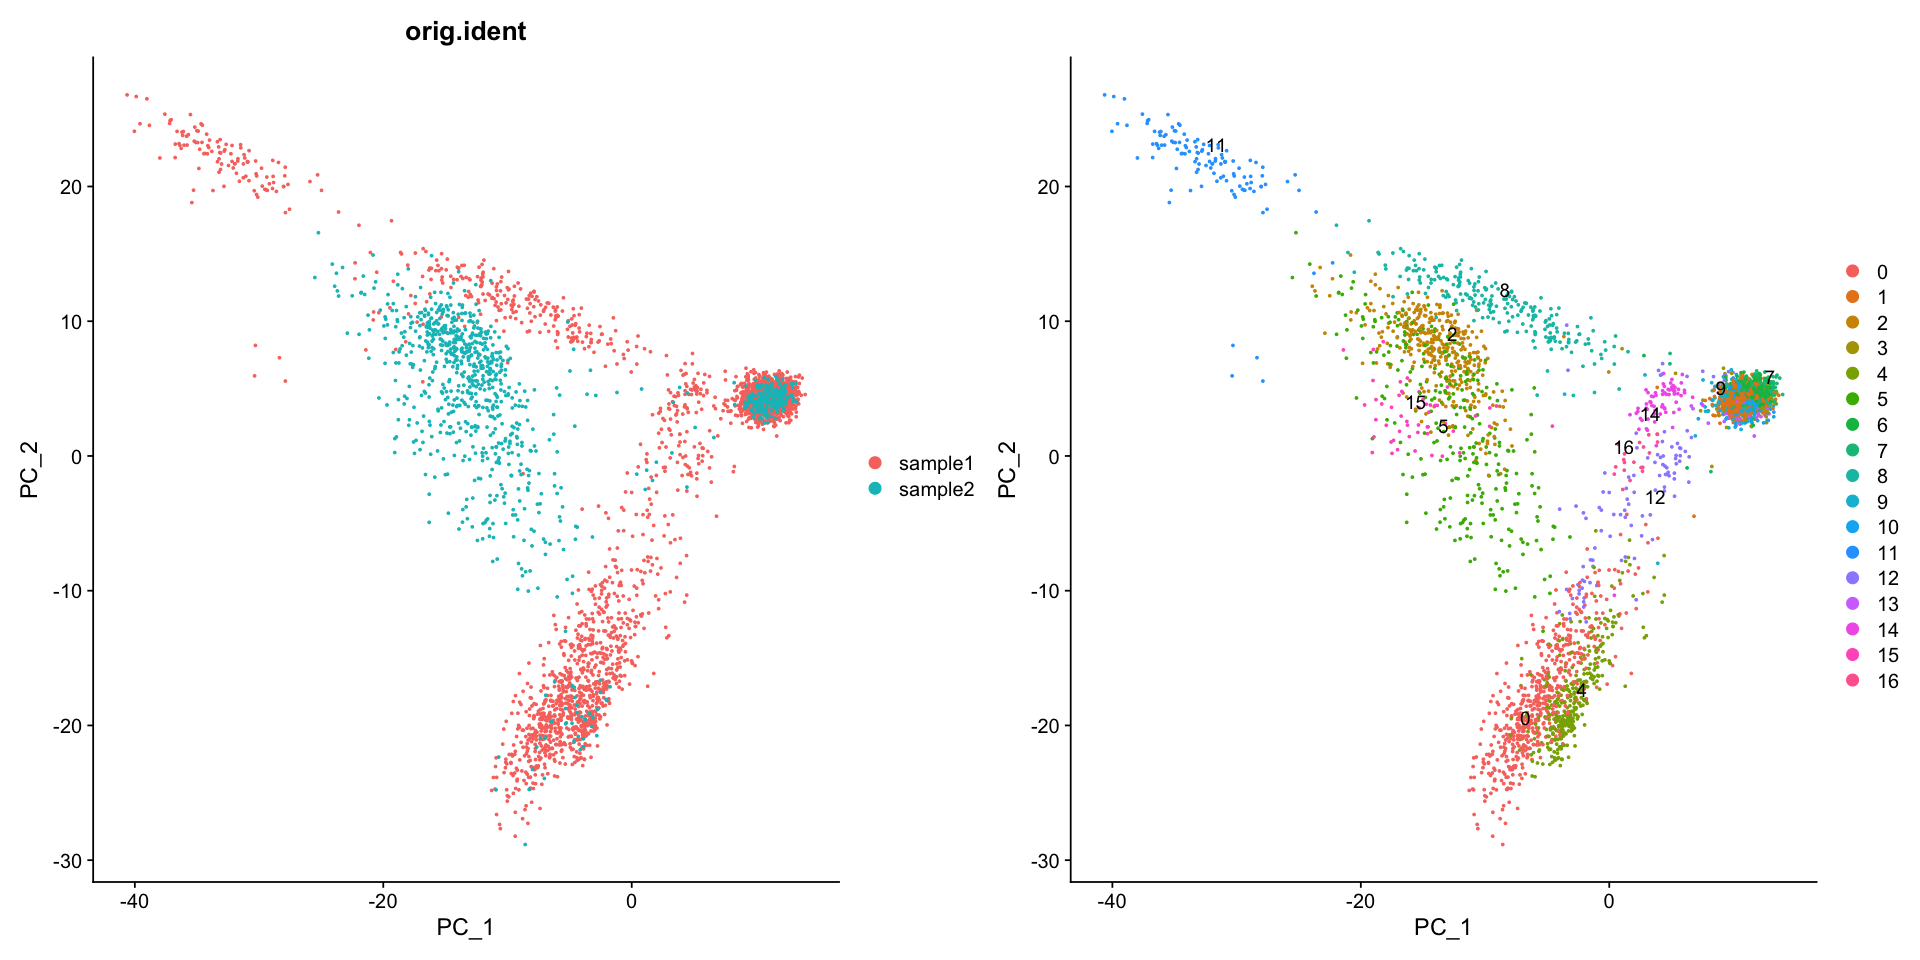

In [12]:
# The reduction variable in DimPlot can be changed to tsne and pca
# All of these plots can be added by copying and pasting the command and changing that variable
options(repr.plot.width=16, repr.plot.height=8)
p1 <- DimPlot(sample.integrated, group.by = "orig.ident")
p2 <- DimPlot(sample.integrated, label = TRUE, repel = TRUE)
p1 + p2

#### From the above plots we can see there is much overlapping in cluster 1, 6 and 10.

#### Plot clusters by sample source

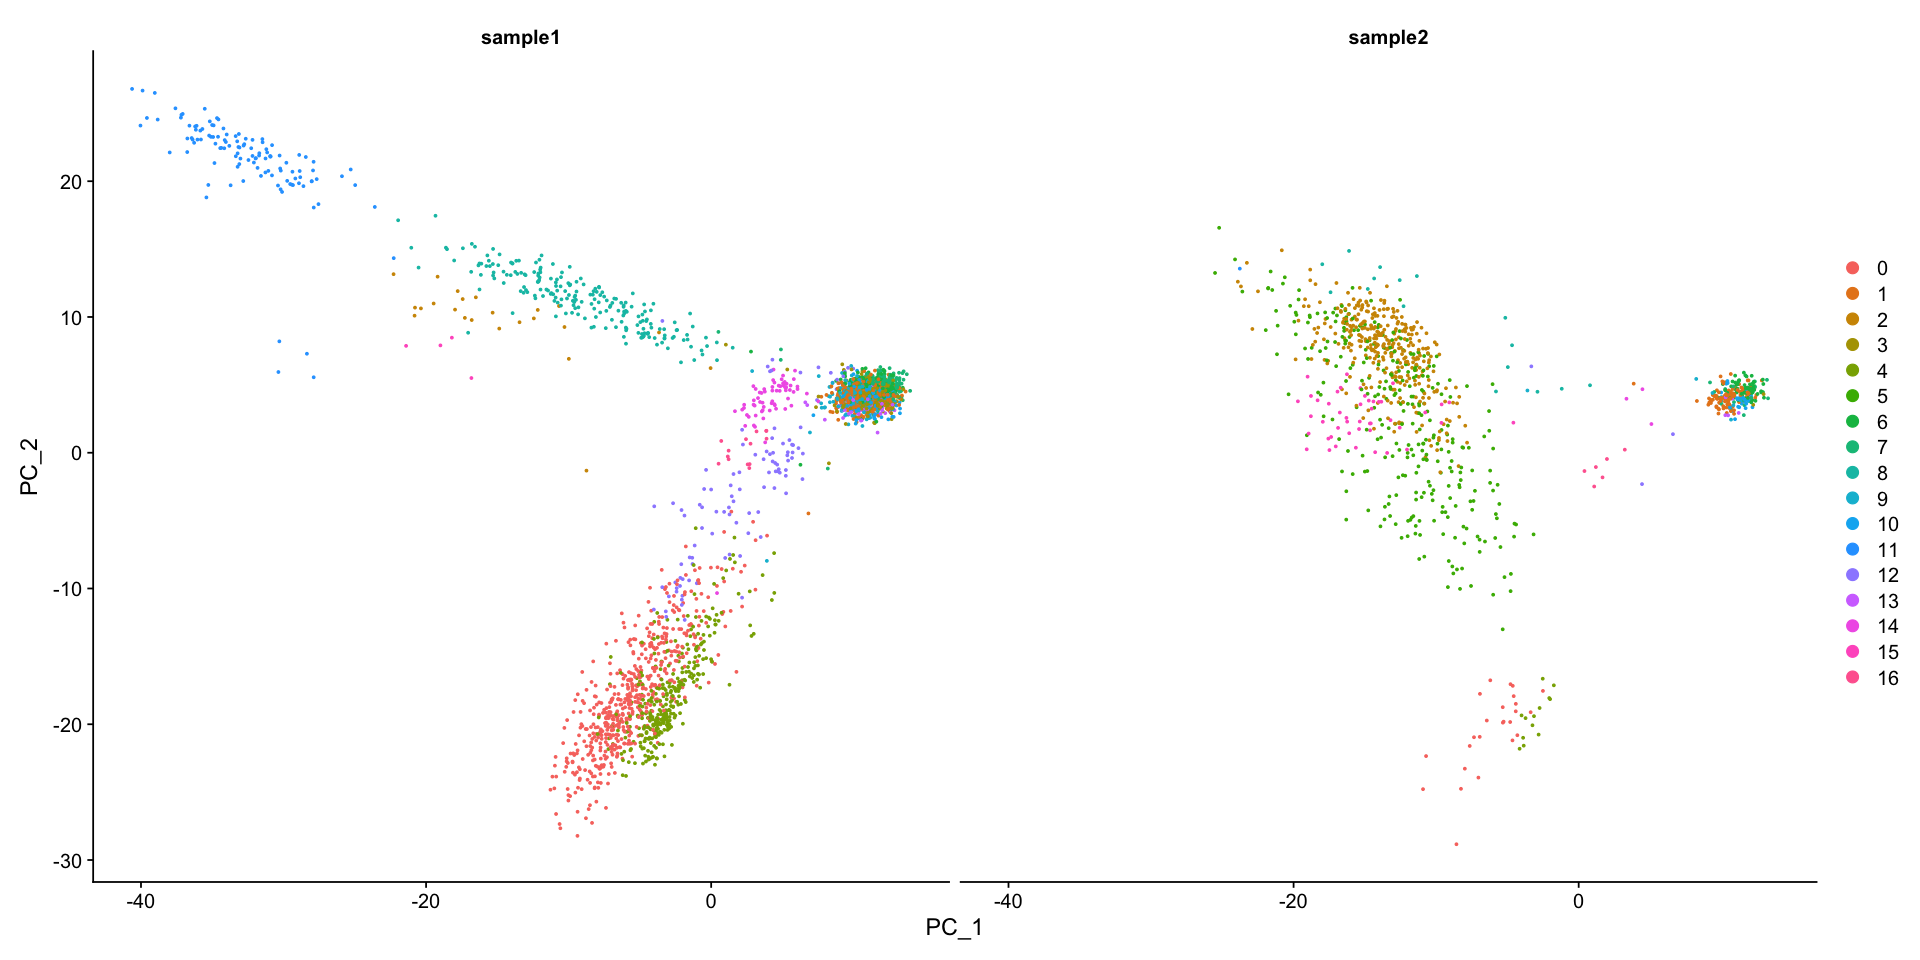

In [15]:
options(repr.plot.width=16, repr.plot.height=8)
DimPlot(sample.integrated, split.by = "orig.ident")

# Identification of highly variable features (feature selection)
#### Calculate a subset of features that exhibit high cell-to-cell variation in the dataset

# Perform linear dimensional reduction
#### Perform PCA on the scaled data. By default, only the previously determined variable features are used as input, but can be defined using features argument if you wish to choose a different subset.

In [16]:
sample1 <- RunPCA(sample.integrated, features = VariableFeatures(object = sample.integrated))

PC_ 1 
Positive:  CTSB, MDK, EMX2OS, FTH1, WFDC2, CLU, CXADR, CST3, IFITM3, CA8 
	   TACSTD2, CD24, PAX8, EPCAM, CFI, EMX2, CLDN4, ELF3, APP, QSOX1 
	   GRN, PLA2G4A, EPHX1, FAM155A, ESR1, RP11-608O21.1, S100A11, SPINT1, MSX1, DEFB1 
Negative:  PTPRC, TRAC, CD96, TRBC2, CD52, CD69, SKAP1, SYTL3, CD7, PRKCH 
	   CD247, CYTIP, CD3E, IL32, CCL5, PDE3B, CD2, CELF2, PTPN22, TOX 
	   HCST, GZMB, SRGN, CTSW, NKG7, GZMA, CAMK4, CD3D, AC104820.2, CORO1A 
PC_ 2 
Positive:  AIF1, PLXDC2, CD14, FMN1, SPI1, FPR1, SLC8A1, LYZ, DOCK4, SLC11A1 
	   KCTD12, CLEC7A, TYROBP, MS4A6A, KYNU, C1orf162, TBXAS1, LST1, LAPTM5, FCER1G 
	   CD86, PLAUR, CSF1R, MARCH1, TGFBI, EPB41L3, S100A9, HCK, RNASE6, PLXNC1 
Negative:  MDK, WFDC2, CLU, CD24, EMX2OS, LAPTM4B, EPCAM, EMX2, PPAP2C, ELF3 
	   CA8, MSX1, CLDN4, DEFB1, PAX8, EPHX1, SELENBP1, SOX17, KRT8, FOLR1 
	   RP11-608O21.1, SBSPON, CLDN3, STXBP6, TPD52L1, TMC5, KRT18, DLX5, C12orf75, FAM155A 
PC_ 3 
Positive:  VWF, HAPLN1, ELTD1, RAMP3, CXorf36, EGFL7, PTPRB,

In [17]:
# Examine and visualize PCA results a few different ways
print(sample.integrated[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  PTPRC, TRAC, CD96, TRBC2, CD52 
Negative:  CTSB, MDK, EMX2OS, FTH1, WFDC2 
PC_ 2 
Positive:  MDK, WFDC2, CLU, CD24, EMX2OS 
Negative:  AIF1, PLXDC2, CD14, FMN1, SPI1 
PC_ 3 
Positive:  VWF, HAPLN1, ELTD1, RAMP3, CXorf36 
Negative:  CD24, TACSTD2, DEFB1, WFDC2, FTH1 
PC_ 4 
Positive:  MKI67, TOP2A, BIRC5, STMN1, CDK1 
Negative:  VCAN, FCN1, S100A12, CFD, THBS1 
PC_ 5 
Positive:  IGFBP7, LUM, IFITM3, DCN, DEFB1 
Negative:  RP11-608O21.1, RP11-123O10.4, DNAH14, ESRRG, PAX8 


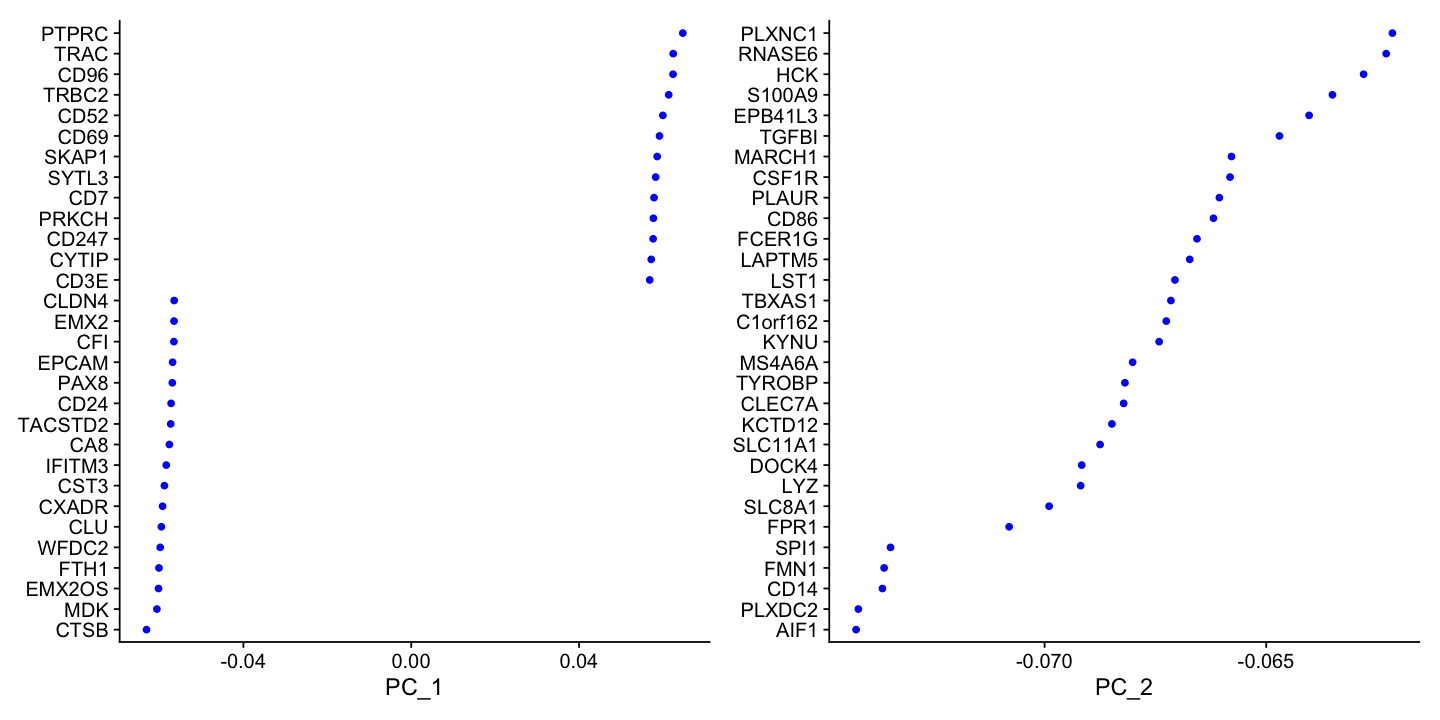

In [18]:
options(repr.plot.width=12, repr.plot.height=6)
VizDimLoadings(sample.integrated, dims = 1:2, reduction = "pca")

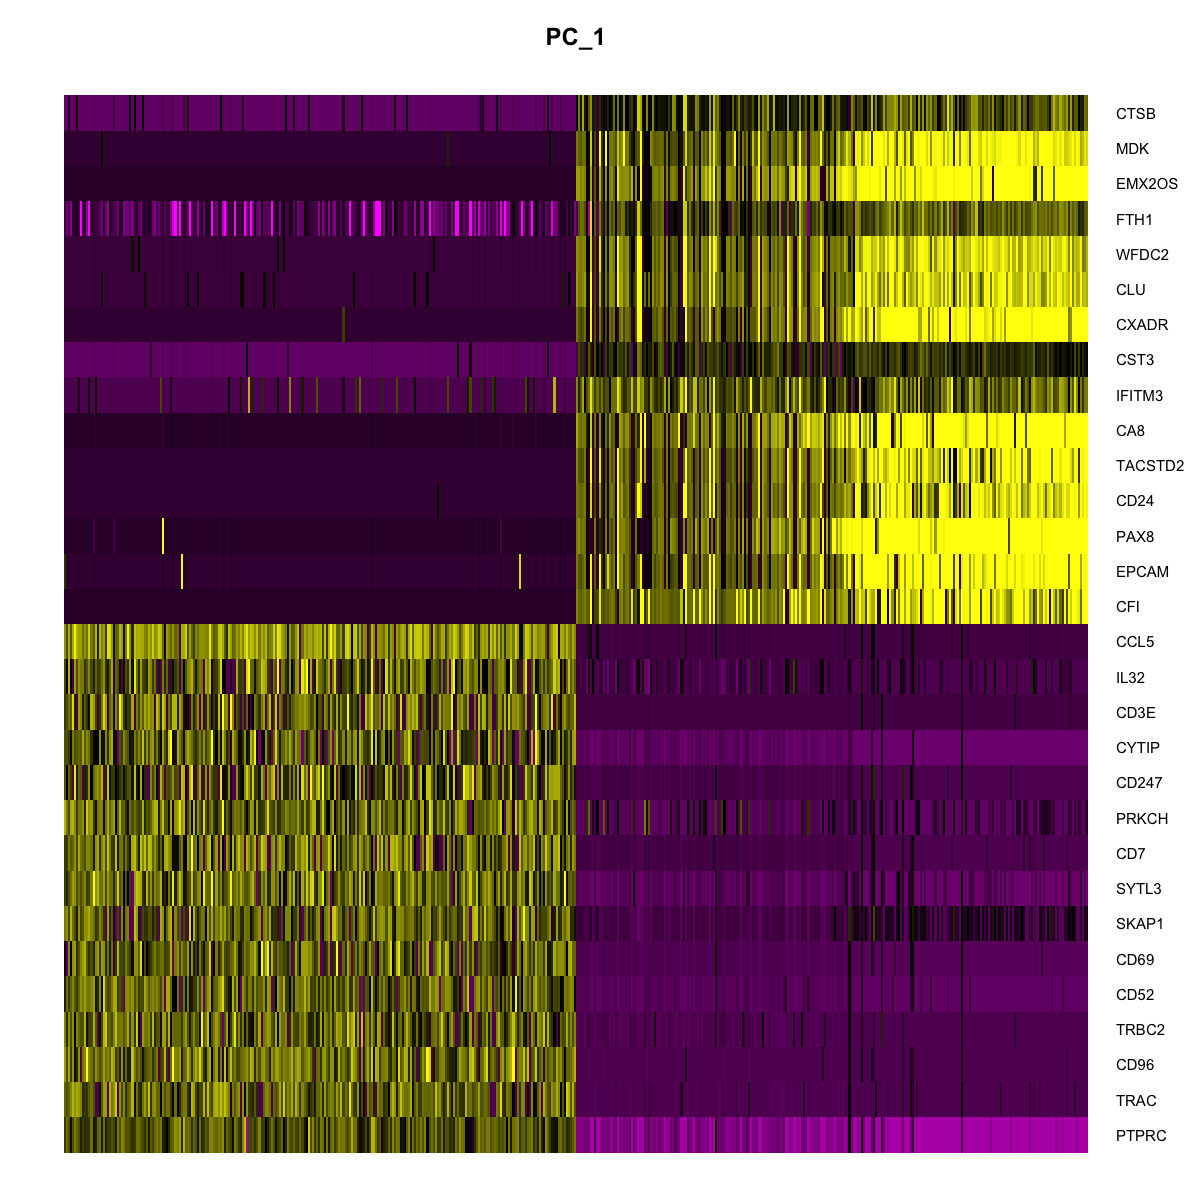

In [19]:
options(repr.plot.width=10, repr.plot.height=10)
DimHeatmap(sample.integrated, dims = 1, cells = 500, balanced = TRUE)

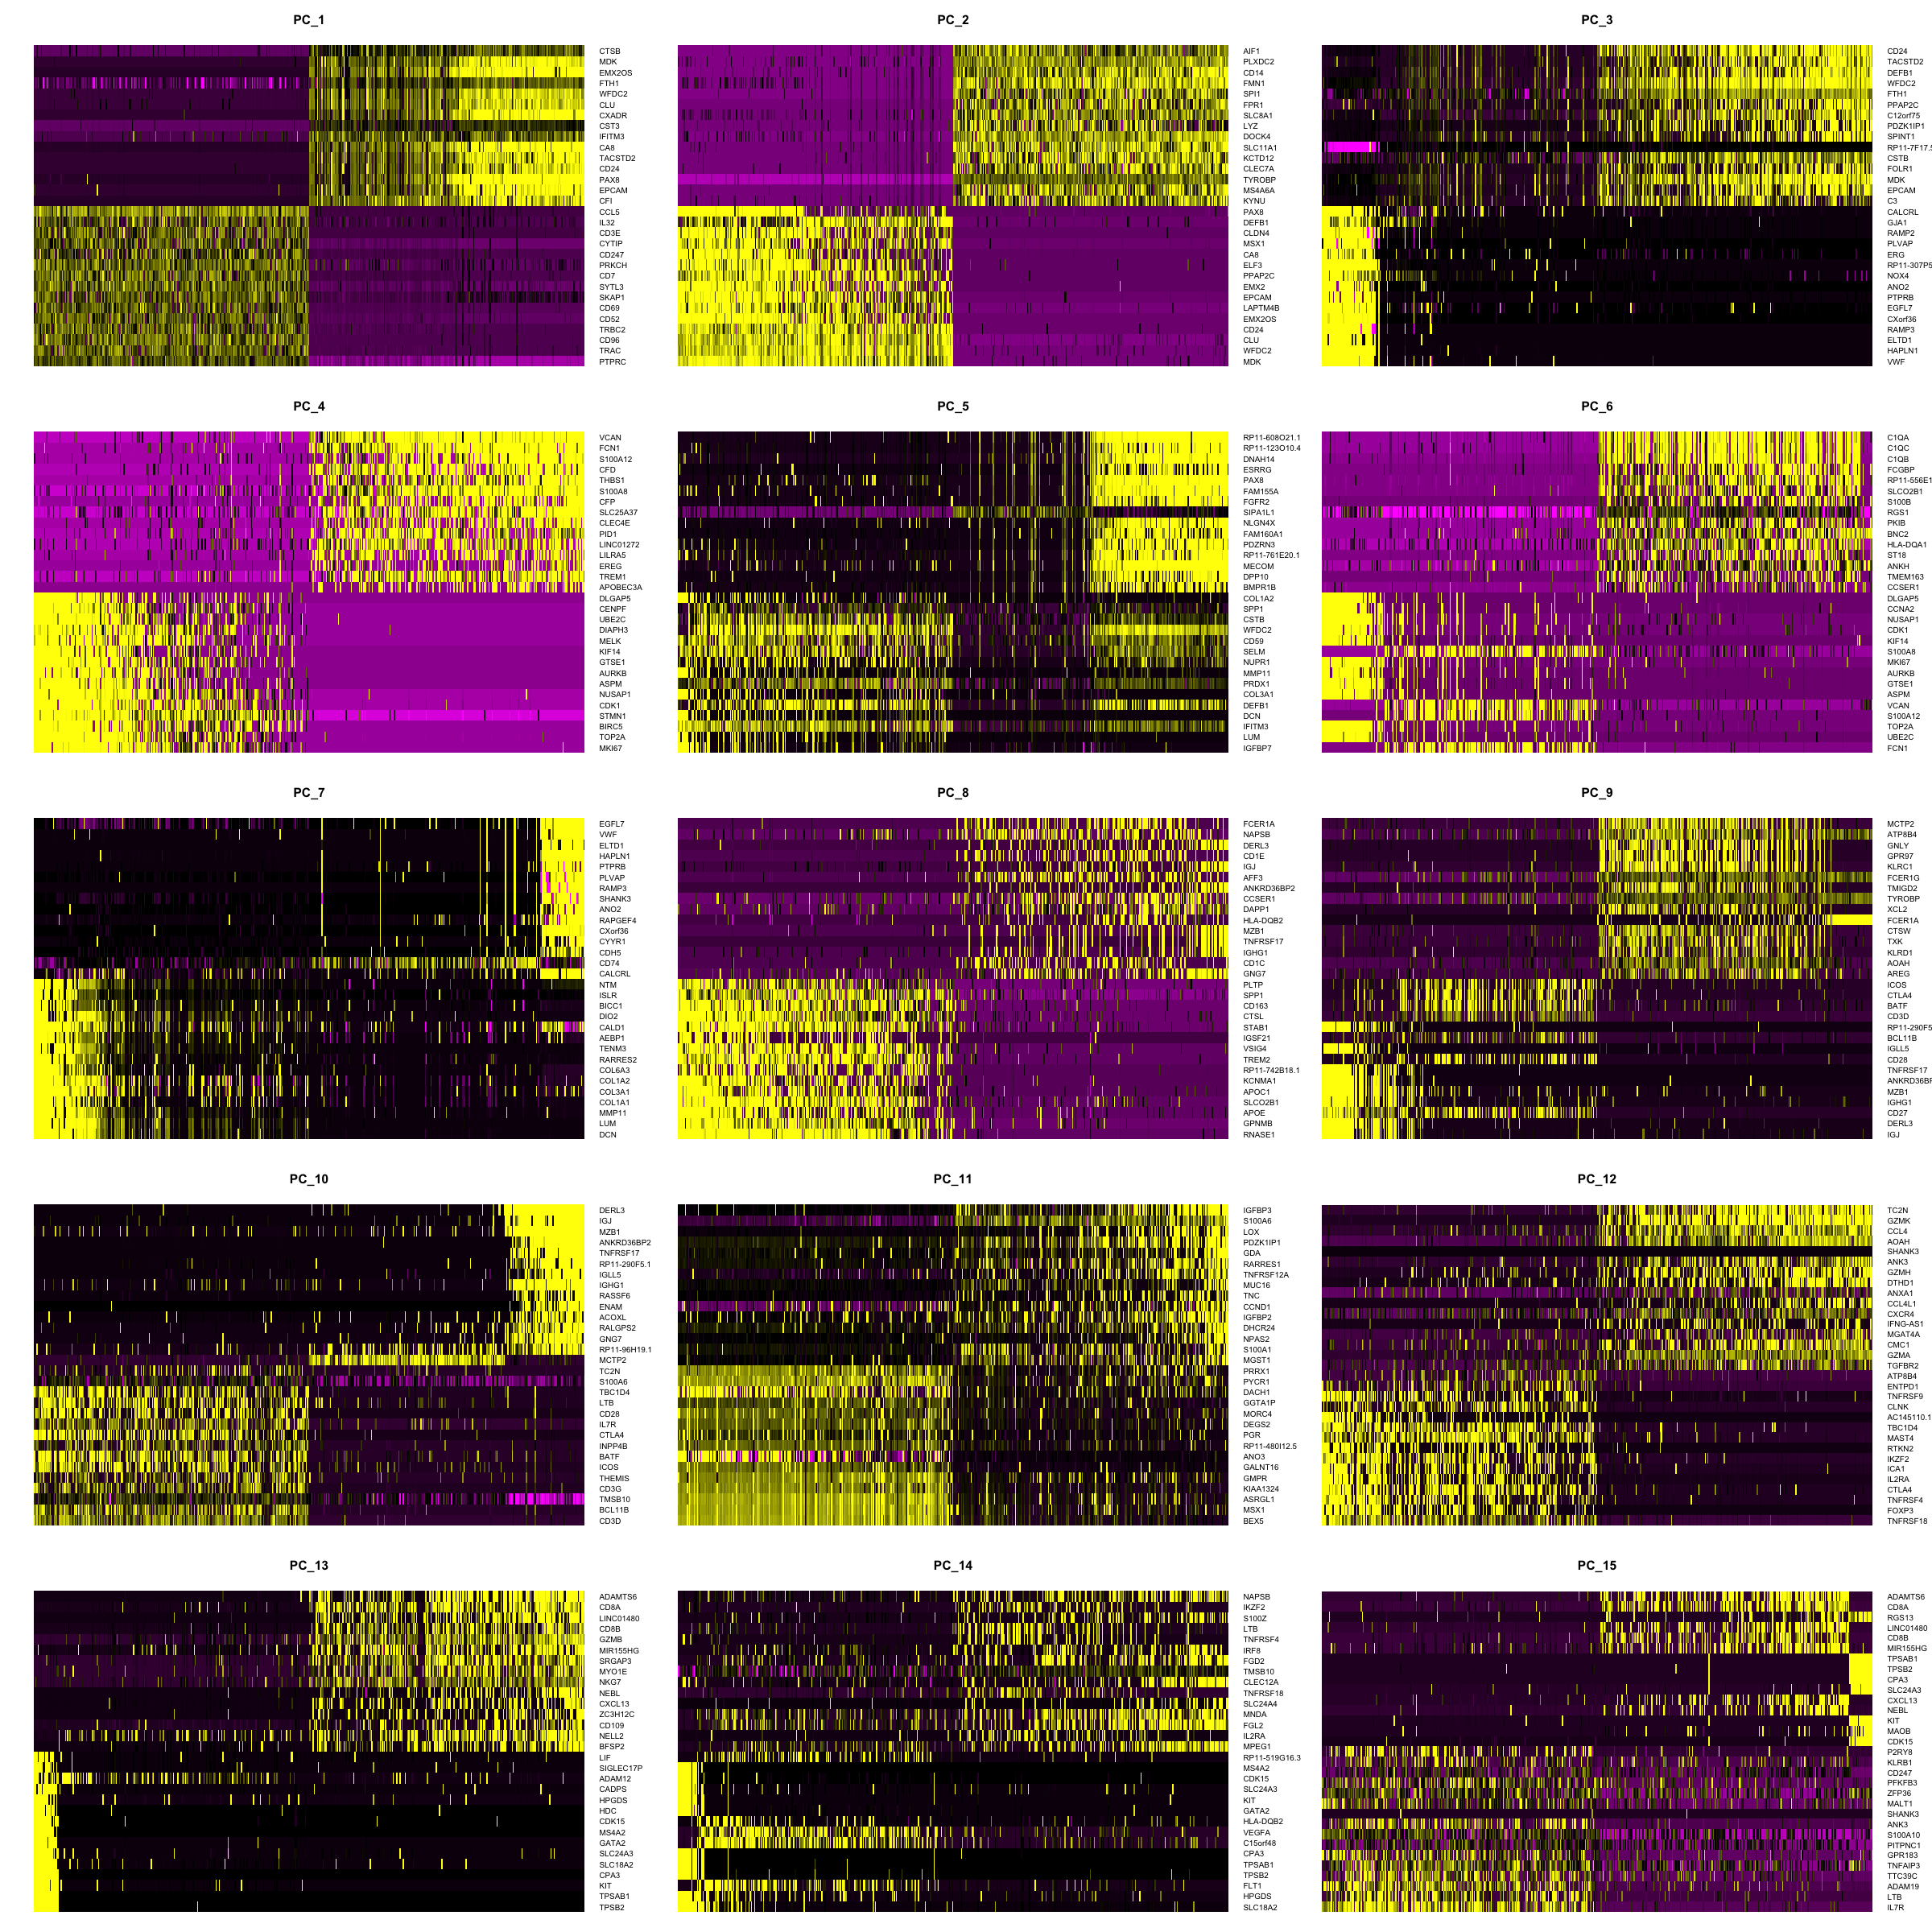

In [20]:
options(repr.plot.width=20, repr.plot.height=20)
DimHeatmap(sample.integrated, dims = 1:15, cells = 500, balanced = TRUE)

# Determine the ‘dimensionality’ of the dataset
#### Implement a resampling test inspired by the JackStraw procedure. Randomly permute a subset of the data (1% by default) and rerun PCA, constructing a ‘null distribution’ of feature scores, and repeat this procedure. Identify ‘significant’ PCs as those who have a strong enrichment of low p-value features.
#### An alternative heuristic method generates an ‘Elbow plot’: a ranking of principle components based on the percentage of variance explained by each one (ElbowPlot() function). In sample1, we can observe an ‘elbow’ around PC18-19, suggesting that the majority of true signal is captured in the first 18 PCs.

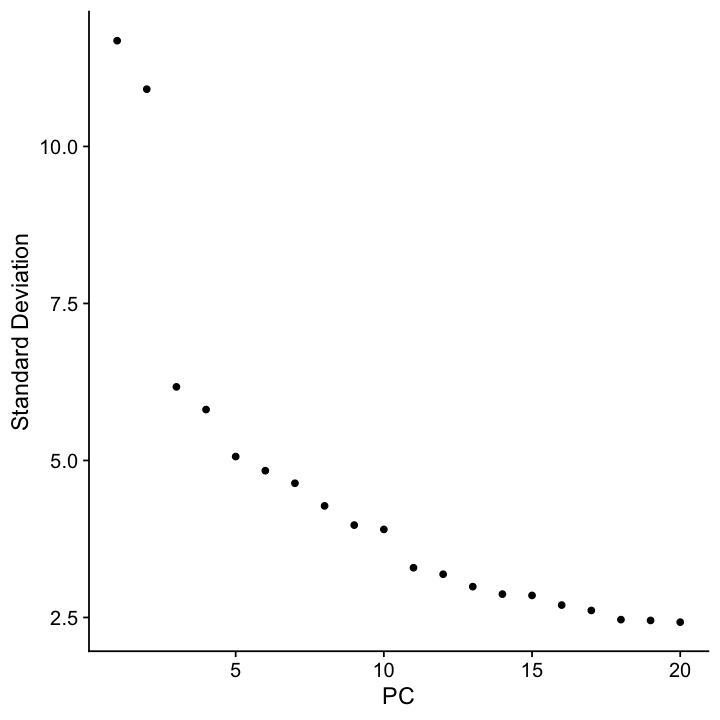

In [21]:
options(repr.plot.width=6, repr.plot.height=6)
ElbowPlot(sample.integrated)

# Cluster the cells #
#### Construct a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods (Jaccard similarity). This step is performed using the FindNeighbors() function, and takes as input the previously defined dimensionality of the dataset (first 18 PCs).
#### Then iteratively group cells together, with the goal of optimizing the standard modularity function. The FindClusters() function implements this procedure, and contains a resolution parameter that sets the ‘granularity’ of the downstream clustering, with increased values leading to a greater number of clusters.

In [22]:
sample1 <- FindNeighbors(sample.integrated, dims = 1:18)
sample1 <- FindClusters(sample.integrated, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3942
Number of edges: 137972

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9343
Number of communities: 17
Elapsed time: 0 seconds


#### The clusters can be found using the *Idents()* function.

In [23]:
# Look at cluster IDs of the first 5 cells
head(Idents(sample1),5)

assay1_AAACCCAAGGATTTAG-1 assay1_AAACCCAAGGCACCAA-1 assay1_AAACCCAAGGTTAAAC-1 
                        6                         9                         1 
assay1_AAACCCAGTAGTACGG-1 assay1_AAACCCAGTCTCTCTG-1 
                        8                         4 
Levels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16

# Run non-linear dimensional reduction (UMAP)
#### Learn the underlying manifold of the data in order to place similar cells together in low-dimensional space. Cells within the graph-based clusters determined above should co-localize on these dimension reduction plots. As input to the UMAP, we suggest using the same PCs as input to the clustering analysis.

In [24]:
sample1 <- RunUMAP(sample1, dims = 1:18, verbose = FALSE)

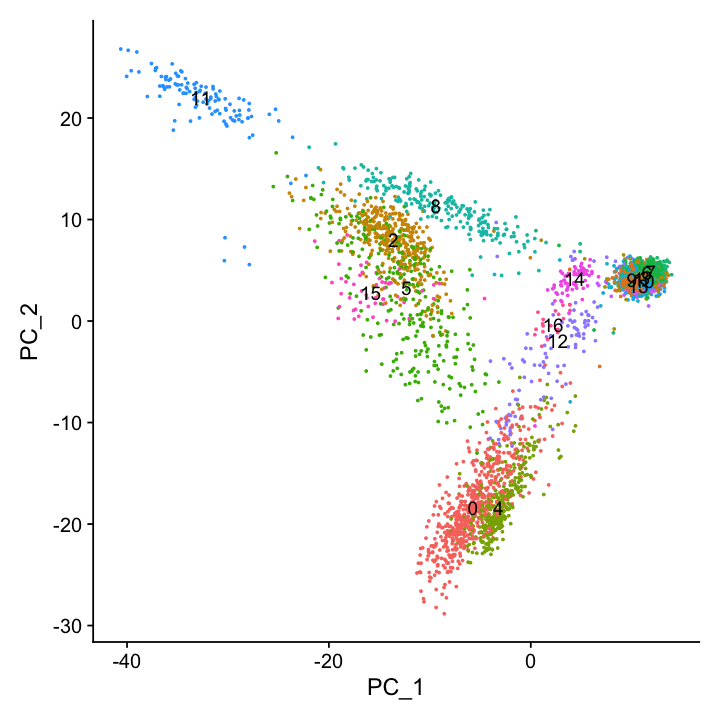

In [26]:
# Can set `label = TRUE` or use the LabelClusters function to help label individual clusters
options(repr.plot.width=6, repr.plot.height=6)
DimPlot(sample.integrated, label = TRUE) + NoLegend()

# Finding differentially expressed features (cluster biomarkers)
####  Identify positive and negative markers of a single cluster (specified in ident.1), compared to all other cells. 

In [34]:
# Find all markers of cluster 2
suppressWarnings(cluster2.markers <- FindMarkers(sample.integrated, ident.1 = 2, min.pct = 0.25))
head(cluster2.markers, n = 5)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CXCL10,0,0.2771010,0.939,0.120,0
LUM,0,2.0564616,0.986,0.098,0
C8orf4,0,0.3168033,0.953,0.070,0
COL8A1,0,0.4094179,0.925,0.048,0
DCN,0,1.2474391,0.914,0.060,0


#### Find marker genes in all clusters

In [28]:
# Find markers for every cluster compared to all remaining cells, report both positive and negative ones
# Seed is set to maitain reproducibility
sample.integrated.markers <- FindAllMarkers(sample.integrated, only.pos = F, min.pct = 0.25, logfc.threshold = 0.25,
                              verbose = F, return.thresh = 0.001, random.seed = 42)

#### Filter for top 2 genes in each cluster

In [29]:
top.markers <- sample.integrated.markers %>%
                    group_by(cluster) %>%
                    slice_max(n = 2, order_by = p_val)
top.markers

p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
0.0006740866,-0.7897473,0.679,0.705,1,0,IQGAP2
0.0006555935,-0.9052161,0.405,0.499,1,0,BATF
0.0009728591,-0.9895626,0.306,0.386,1,1,CTSL
0.0008818924,-0.3538536,0.274,0.303,1,1,RARRES1
0.0009411159,-1.3286080,0.942,0.582,1,2,PRKCB
0.0007549650,-0.3690814,0.575,0.366,1,2,MNDA
0.0009424900,0.5816730,0.423,0.456,1,3,KLHL6
0.0008852801,-0.3012921,0.267,0.466,1,3,RP11-779O18.3
0.0008680424,-0.2617694,0.229,0.362,1,4,RAB13


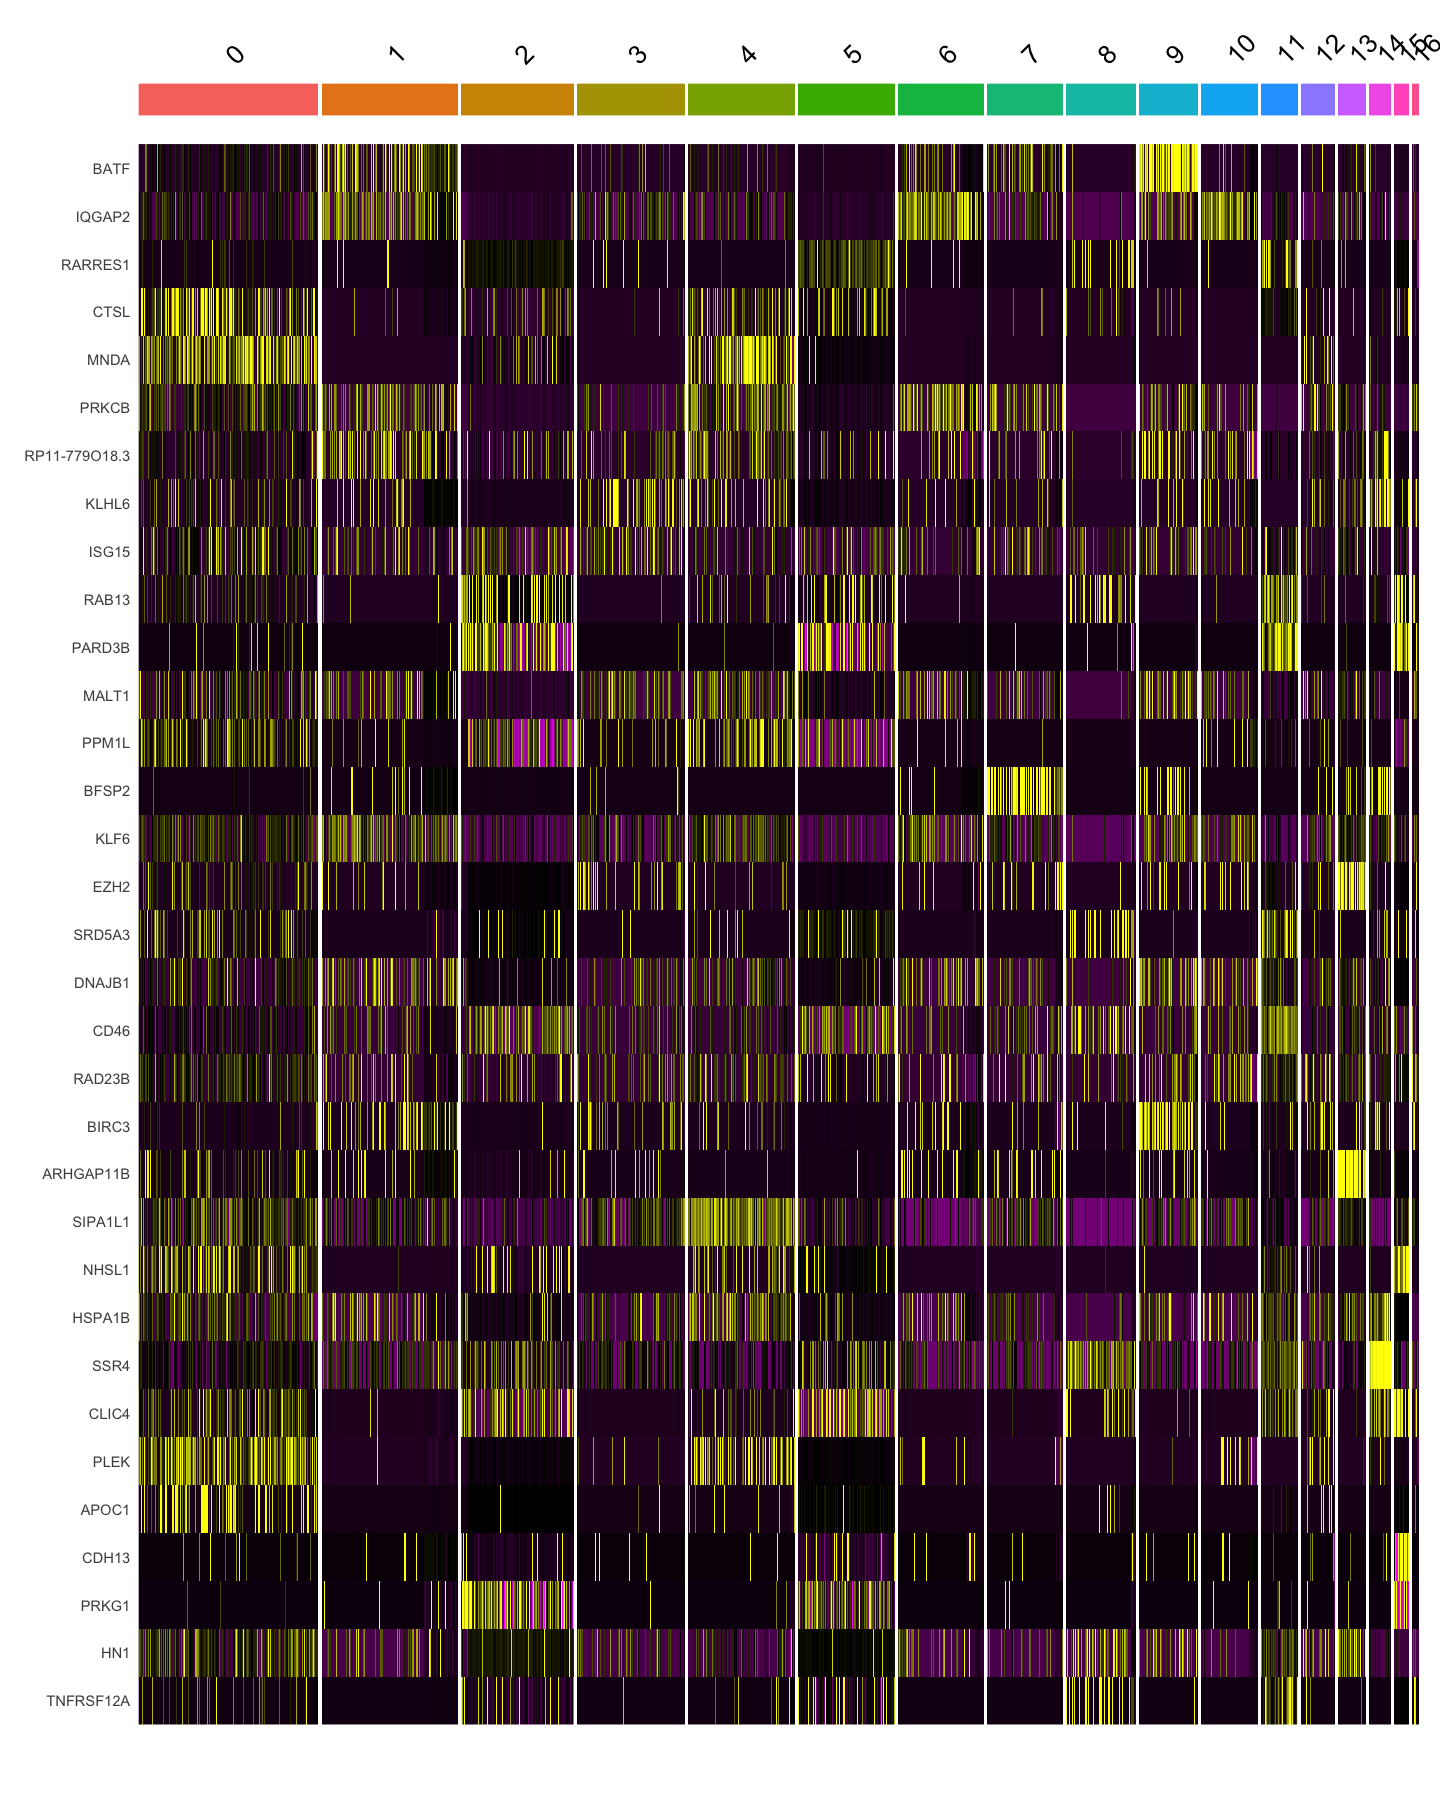

In [30]:
# Visualize expression heatmap for top 2 markers in each cluster
options(repr.plot.width=12, repr.plot.height=15)
sample.integrated.markers %>%
    group_by(cluster) %>%
    top_n(n = 2, wt = p_val) -> top2
DoHeatmap(sample.integrated, features = top2$gene) + NoLegend()

#### Compare cluster 1 to clusters 0 and 4 and find distinguishing features

In [31]:
# Find all markers distinguishing cluster 1 from clusters 0 and 4
sample.integrated.markers <- FindMarkers(sample.integrated, ident.1 = 1, ident.2 = c(0, 4), min.pct = 0.25)
head(sample.integrated.markers)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
TRBC2,8.810959e-193,3.211376,0.925,0.156,1.762192e-189
CD3D,3.250198e-192,2.807987,0.911,0.124,6.500396e-189
TRAC,1.111169e-191,3.163744,0.934,0.171,2.222337e-188
CST3,1.391587e-189,-4.217908,0.269,0.986,2.783174e-186
PLXDC2,5.198080e-189,-4.345531,0.226,0.980,1.039616e-185
FCER1G,7.786983e-189,-3.860272,0.288,0.988,1.557397e-185


#### Visualize expression of these 6 genes 

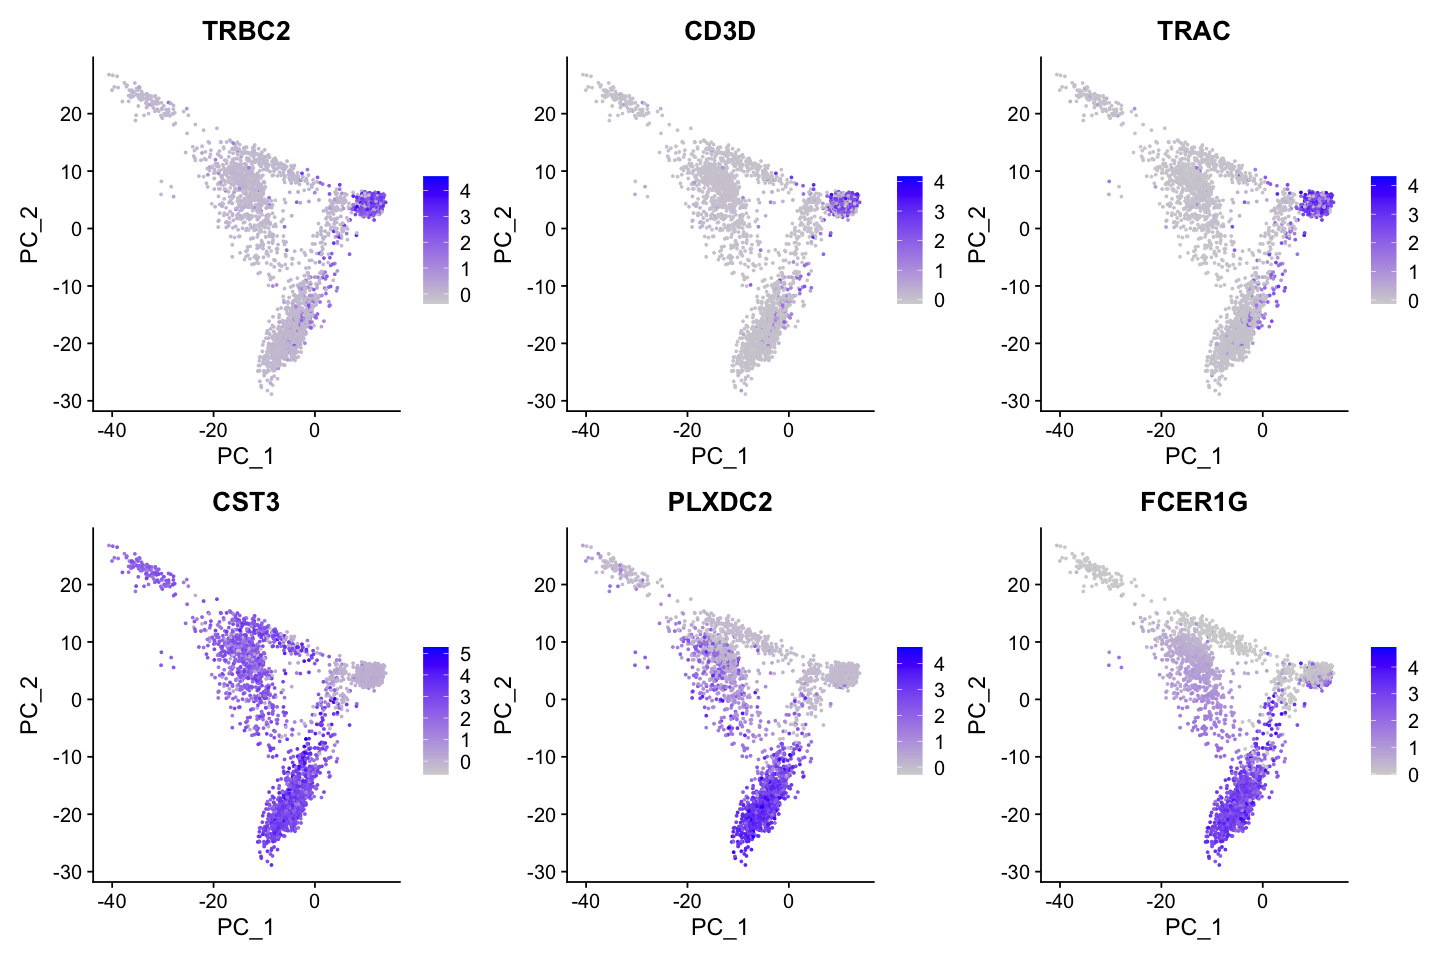

In [32]:
# This is visualizing the marker genes distinguishing cluster 1 from clusters 0 and 4
# Using FeaturePlot()
options(repr.plot.width=12, repr.plot.height=8)
FeaturePlot(sample.integrated, features = c('TRBC2','CD3D','TRAC','CST3','PLXDC2','FCER1G'), ncol = 3)

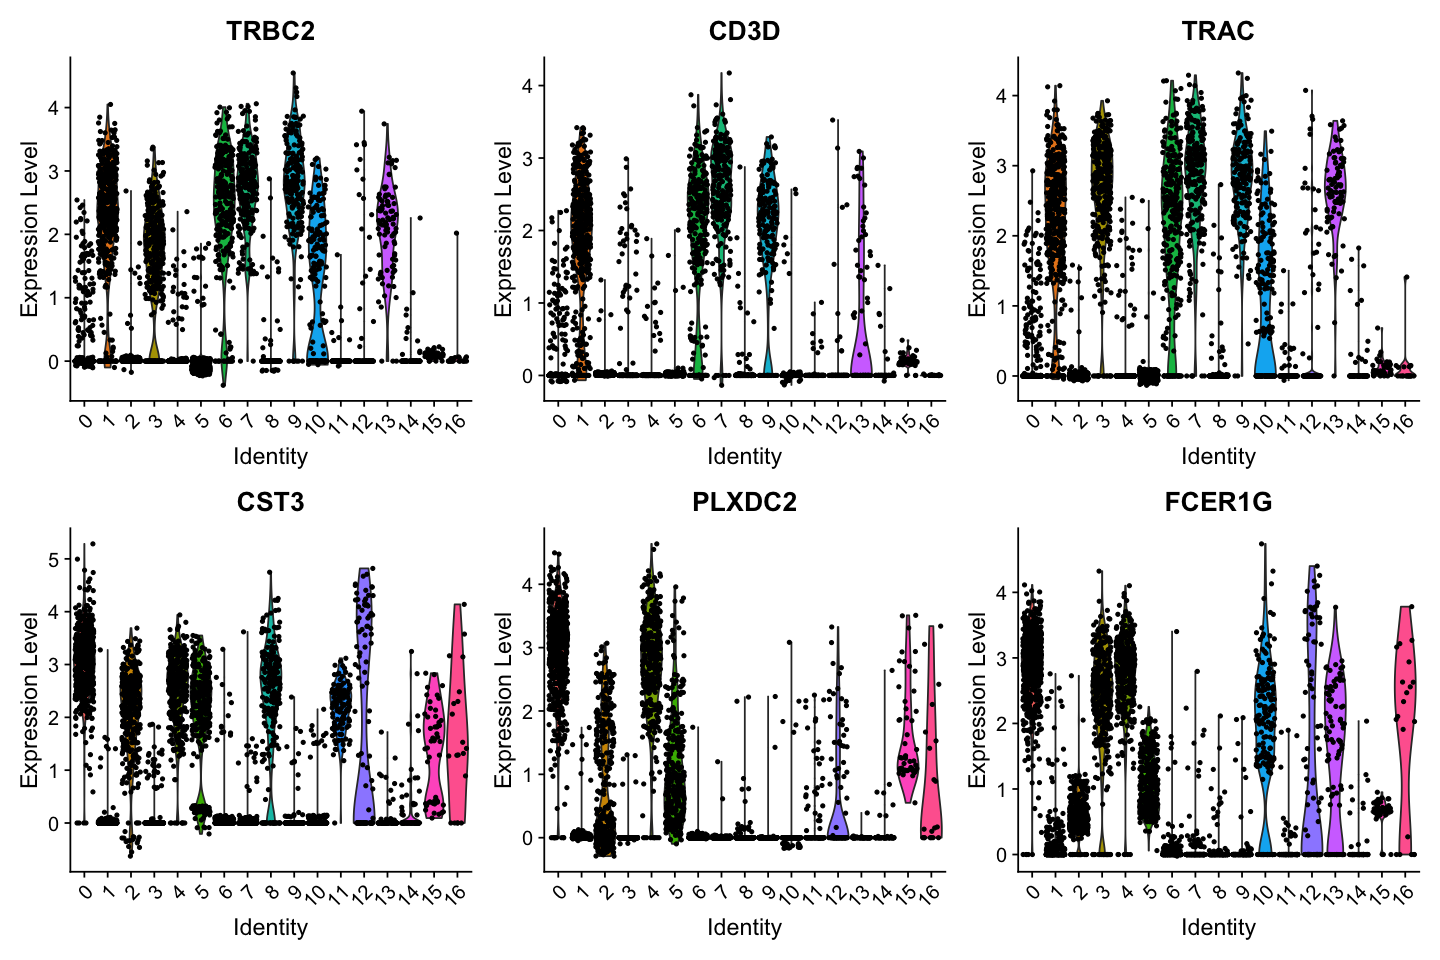

In [33]:
# Using Vlnplot()
VlnPlot(sample.integrated, features = c('TRBC2','CD3D','TRAC','CST3','PLXDC2','FCER1G'))